# TensorFlow Object Detection: Тестирование модели

https://github.com/tensorflow/models/tree/master/research/object_detection

### Монтирование Google Drive
Для данного демо нам понадобятся несколько ноутбуков, которые должны работать с одними и теме же данными. Поэтому, чтобы все ноутбуки имели доступ к нужным данным, нам будет необходимо подключить диск Google Drive и сохранять все данные на нём (включая данные, скачанные из интернета).

Для монтирования диска нужно выполнить данный блок, перейти по ссылке, получить код, скопировать его в поле ниже (в этом блоке) и нажать Enter

После монтирования диск будет находиться здесь: `/content/drive/My Drive`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Рабочая директория
Все данные будем хранить в директории `/content/drive/My Drive/tf_od_demo` (TensorFlow Object Detection Demo)

Директория должна быть уже создана (в предыдущем ноутбуке)

In [2]:
%cd "/content/drive/My Drive/tf_od_demo"

/content/drive/My Drive/tf_od_demo


### Загрузка библиотек
Загрузка TensorFlow и других библиотек. Кроме того, загрузка различных модулей из пакета `object_detection`.

In [13]:
import numpy as np
from matplotlib import pyplot as plt
import imageio

import tensorflow as tf

import sys
sys.path.insert(0, 'models/research')

#from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### Загрузка соответствия имён классов и их ID

In [14]:
PATH_TO_LABELS = 'my_data/cube_label_map.pbtxt'

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Загрузка замороженного графа для инференса

In [17]:
PATH_TO_FROZEN_GRAPH = 'my_data/output/frozen/frozen_inference_graph.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
    #od_graph_def = tf.GraphDef()
    od_graph_def = tf.compat.v1.GraphDef()
    #with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    with tf.compat.v2.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Функция для детектирования объектов на одном изображении

In [24]:
import tensorflow.compat.v1 as tf

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: image})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[ 'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

### Запуск детектрования объектов

In [25]:
image_np = imageio.imread('my_data/test.jpg')
image_np_expanded = np.expand_dims(image_np, axis=0)

output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)

### Визуализация результатов детектирования
Визуализируем получившиеся детекции. Здесь их можно дополнительно отфильтровать по скору, используя `min_score_thresh`

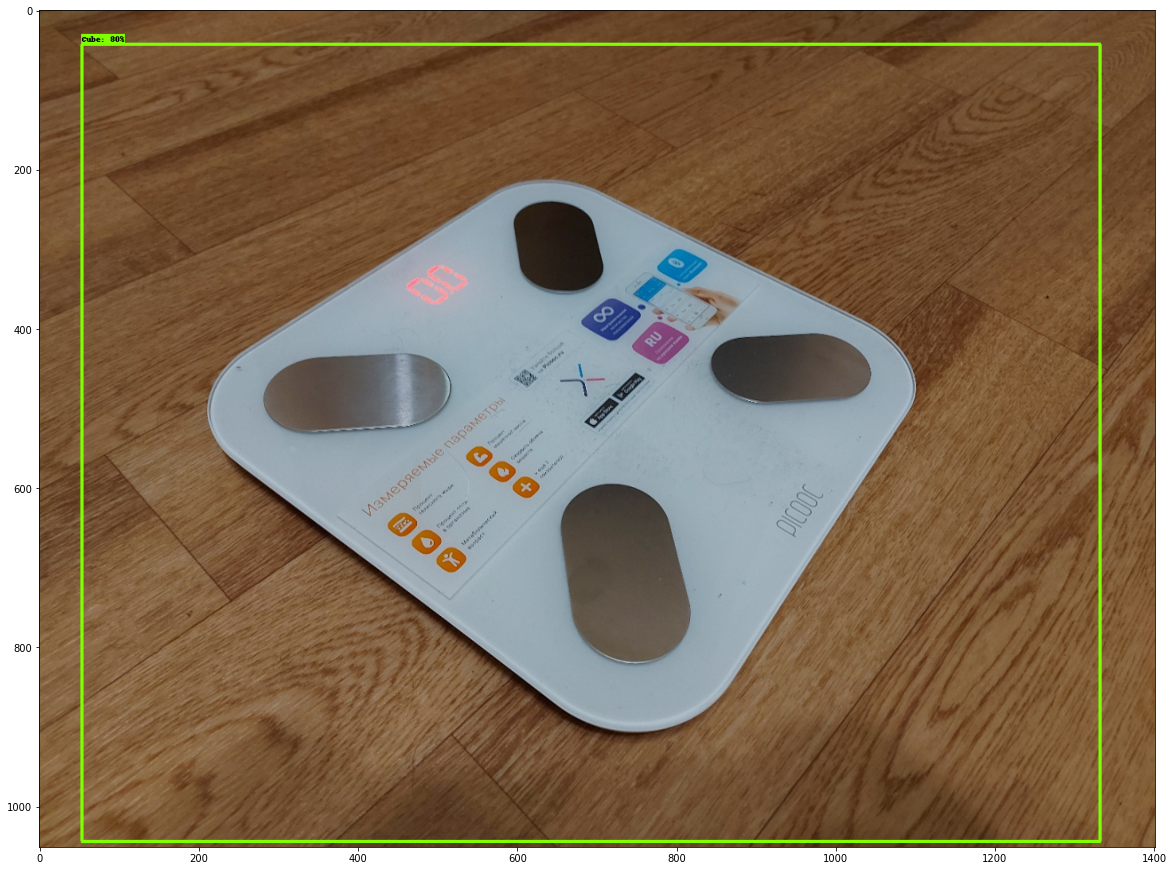

In [33]:
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=4,
    min_score_thresh=0.8)

%matplotlib inline
plt.figure(figsize=(20,20))
plt.imshow(image_np)